In [1]:
# Basic inputs
import numpy as _np
import matplotlib.pyplot as _plt

In [2]:
# Make sure that you can import my local analysis stuff
import os, sys

forceit = 0
# wdir = os.path.abspath(os.path.join(os.path.curdir, '..', '..'))
wdir = os.path.join('C:/', 'Users', 'gawe', 'Workshop')
if forceit or (os.path.join(wdir, 'pyanalysis') not in sys.path):
    sys.path.append(wdir)
    sys.path.append(os.path.join(wdir, 'pyanalysis'))      


In [3]:
# Fast-fourier transform stuff
try:
    from FFT import fft as fftmod     # automatically chooses between numpy, fftw, etc.
    from FFT.spectrogram import stft  # short time fast fourier transform
    from FFT.windows import windows   # window function definitions
    from FFT.fft_analysis import fftanal  # class for using welchs averaged periodogram method
except:
    from . import fft as fftmod
    from .spectrogram import stft 
    from .windows import windows
    from .fft_analysis import fftanal

AMPLITUDE MODULATED SIGNALS

Example of Single-frequency Amplitude modulation in signals
    $$x_{AM}(t) = \sin(\omega_c t)(1+x_{BB}(t))$$
where $$\sin(\omega_c t)$$ represents the carrier term. The first part is shifting the baseband amplitude up (above zero) and the second term is modulating that signal

Text(0.5, 1.0, 'Amplitude modulated signals')

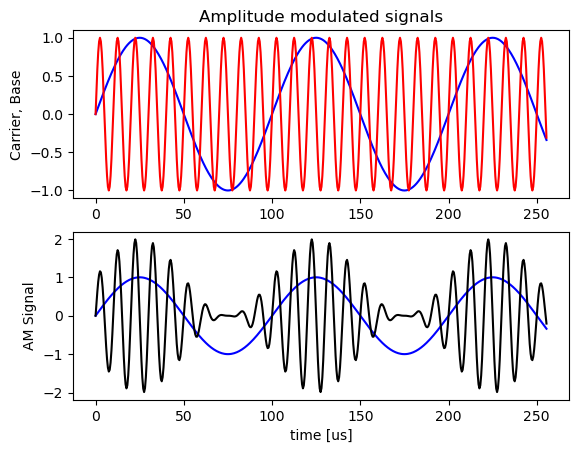

In [4]:
f_b = 10e3  # 10 KHz baseband frequency
f_c = 100e3 # 100 KHz carrier frequency
Fs = 2e6    # 2 MHz sampling frequency

BufferLength = 2048
HalfBuff = BufferLength // 2
n = _np.asarray(range(BufferLength), dtype=int)

sig_b = _np.sin(2*_np.pi*n / (Fs/f_b) )  # baseband signal
sig_c = _np.sin(2*_np.pi*n / (Fs/f_c) )  # carrier signal

sig_am = sig_c * (1.0 + sig_b)  # Amplitude-modulated signal
t_am = 1e6*n/Fs

hfig, _ax = _plt.subplots(2, 1)
_ax[0].plot(t_am[:HalfBuff//2], sig_b[:HalfBuff//2], 'b-', t_am[:HalfBuff//2], sig_c[:HalfBuff//2], 'r')
_ax[0].set_ylabel('Carrier, Base')
_ax[1].plot(t_am[:HalfBuff//2], sig_b[:HalfBuff//2], 'b-', t_am[:HalfBuff//2], sig_am[:HalfBuff//2], 'k-')
_ax[1].set_ylabel('AM Signal')
_ax[1].set_xlabel('time [us]')
_ax[0].set_title('Amplitude modulated signals')

In frequency space there is a strong peak at the carrier frequency, and the amplitude modulation causes uppper- and lower-sidebands to appear at frequencies equal to the carrier plus / minus the baseband signal frequency

Using a periodic Hanning window function
(SLDR~f**-3, PSLL=-31.5dB, ROV=50.0%, AF=1.000, PF=0.707, OC=0.167)


(0.0, 200.0)

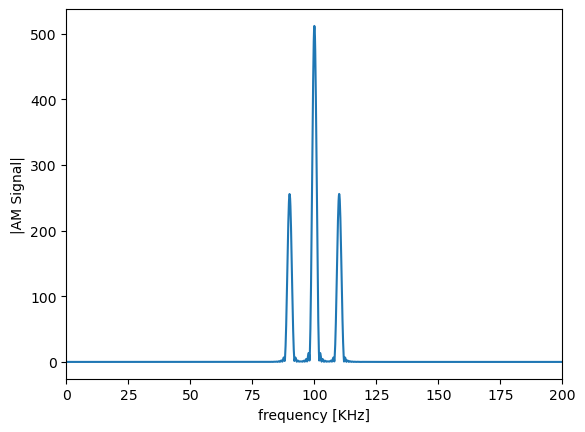

In [5]:
# nfft = BufferLength    # no ringing, but poor resolution
# nfft = BufferLength    # ringing
# nfft = 4*BufferLength    # ringing
nfft = 8*BufferLength

win = windows('hann', periodic=True, verbose=True, nwins=BufferLength)

df = Fs/nfft
freq = _np.arange(0, Fs/2-df, step=df)

AM_dft = fftmod.fft(win*sig_am, n=nfft)
# win_dft = fftmod.fft(win, n=nfft)

_, _ax1 = _plt.subplots(1,1)
# _, (_ax1, _ax2) = _plt.subplots(1,2, sharex=True)

_ax1.plot(1e-3*freq, _np.abs(AM_dft[:nfft//2-1]))
_ax1.set_xlabel('frequency [KHz]')
_ax1.set_ylabel('|AM Signal|')
_ax1.set_xlim((0, 100*_np.ceil(2*f_c/100e3)))

# _ax2.plot(1e-3*freq, _np.abs(win_dft[:nfft//2-1]), '-')
# _ax2.set_xlabel('frequency [KHz]')
# _ax2.set_ylabel('Window func.')
# _ax2.set_xlim((0, 100*_np.ceil(2*f_c/100e3)))


FREQUENCY MODULATED SIGNALS

In contrast to amplitude modulation, frequency modulation is achieved by adding the integral of the baseband signal tot he argument of the carrier signal,
    $$x_{FM}(t) = \sin(\omega_c t + \int_{-\infty}^{t} x_{BB}(t) dt ).$$

In this way, the instantaneous frequency of the carrier wave is directly modulated by the baseband signal.

In contrast, phase modulation is achieved by directly adding the baseband signal to the carrier's argument in order to modify its instantaneous phase, 
    $$x_{PM}(t) = \sin(\omega_c t + x_{BB}(t) ).$$

Using a periodic Hanning window function
(SLDR~f**-3, PSLL=-31.5dB, ROV=50.0%, AF=1.000, PF=0.707, OC=0.167)


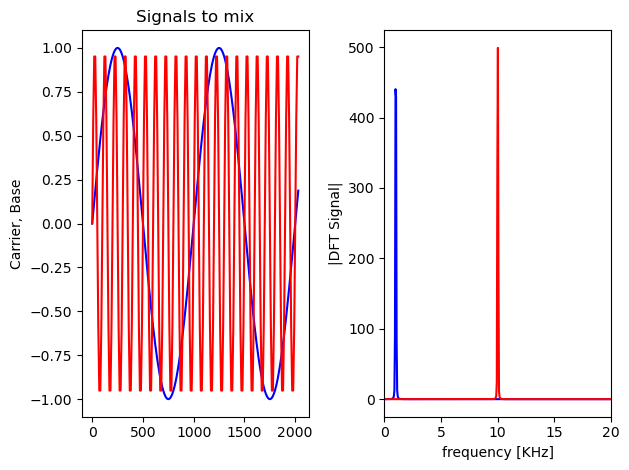

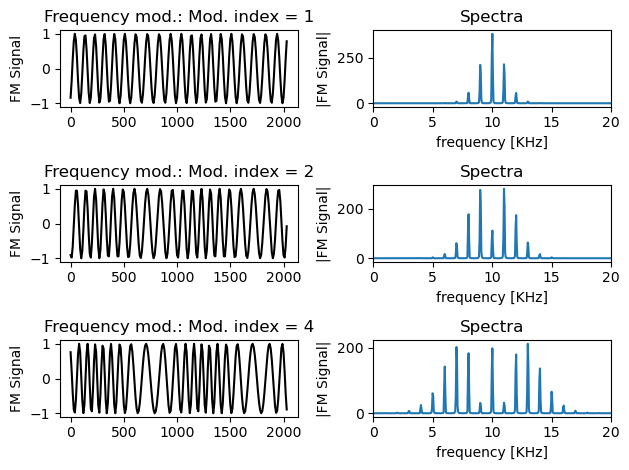

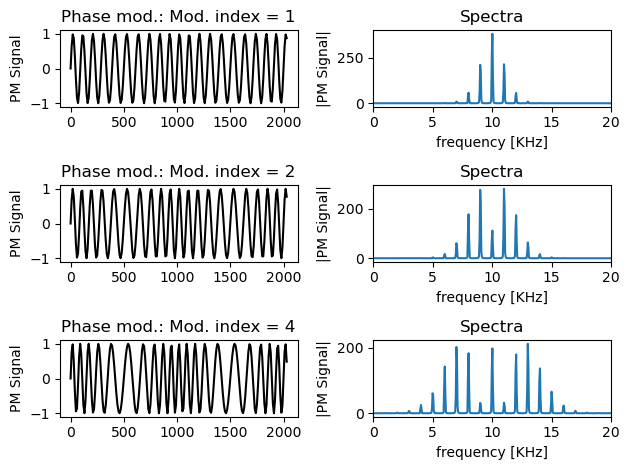

In [6]:
FreqSepFactor = 10
Fs = 100e3    # 10 MHz sampling frequency
f_b = 1e3             # baseband frequency
# f_b = 10e3  # 10 KHz baseband frequency
f_c = FreqSepFactor*f_b  # Carrier frequency

# flim = 100*_np.ceil(2*f_c/100e3)
# flim = 100*_np.ceil(2*f_c/50e3)
# flim = 1e-3*freq[-1]
flim = _np.ceil(2*f_c/1e3)

ModIndex = [int(1), int(2), int(4)]  # modulation index

BufferLength = 2048
# HalfBuff = BufferLength // 2
PartBuff = BufferLength // FreqSepFactor

n = _np.asarray(range(BufferLength), dtype=int)
t_m = 1e6*n/Fs

sig_b = _np.sin(2*_np.pi*n / (Fs/f_b) )  # baseband signal
sig_c = _np.sin(2*_np.pi*n / (Fs/f_c) )  # carrier signal

# We could use a numerical method to integrate the baseband signal, but we can also do it analytically
sig_b_int = -1.0*_np.cos(2*_np.pi*n / (Fs/f_b) )

# ==== FFT parameters ===== #
nfft = BufferLength    # no ringing, but poor resolution
# nfft = BufferLength    # ringing
# nfft = 4*BufferLength  # ringing
# nfft = 8*BufferLength

df = Fs/nfft
freq = _np.arange(0, Fs/2-df, step=df)
win = windows('hann', periodic=True, verbose=True, nwins=BufferLength)

dft_b = fftmod.fft(win*sig_b, n=nfft) 
dft_c = fftmod.fft(win*sig_c, n=nfft) 
    
# ==== Modulation ===== #

hfig, _ax = _plt.subplots(1, 2)
hfig1, _ax1 = _plt.subplots(3, 2)
hfig2, _ax2 = _plt.subplots(3, 2)

_ax[0].plot(t_m[:PartBuff], sig_b[:PartBuff], 'b-', t_m[:PartBuff], sig_c[:PartBuff], 'r-')
_ax[0].set_ylabel('Carrier, Base')
_ax[0].set_title('Signals to mix')

_ax[1].plot(1e-3*freq, _np.abs(dft_b[:nfft//2-1]), 'b-', 1e-3*freq, _np.abs(dft_c[:nfft//2-1]), 'r-')
_ax[1].set_xlabel('frequency [KHz]')
_ax[1].set_ylabel('|DFT Signal|')
_ax[1].set_xlim((0, flim))


sig_pm = []
sig_fm = []
dft_pm = []
dft_fm = []
for ii in range(3):
    sig_pm.append(_np.sin( (2.0*_np.pi*n/(Fs/f_c)) + ModIndex[ii]*sig_b ) ) # Phase modulated signal
    sig_fm.append(_np.sin( (2.0*_np.pi*n/(Fs/f_c)) + ModIndex[ii]*sig_b_int ) )  # Frequency modulated signal

    dft_fm.append( fftmod.fft(win*sig_fm[ii], n=nfft) )
    dft_pm.append( fftmod.fft(win*sig_pm[ii], n=nfft) )


    _ax1[ii,0].plot(t_m[:PartBuff], sig_fm[ii][:PartBuff], 'k-')
    _ax1[ii,0].set_ylabel('FM Signal')
    _ax1[ii,0].set_title('Frequency mod.: Mod. index = %i'%(ModIndex[ii],))

    _ax1[ii,1].plot(1e-3*freq, _np.abs(dft_fm[ii][:nfft//2-1]))
    _ax1[ii,1].set_xlabel('frequency [KHz]')
    _ax1[ii,1].set_ylabel('|FM Signal|')
    _ax1[ii,1].set_title('Spectra')
    _ax1[ii,1].set_xlim((0, flim))

    _ax2[ii,0].plot(t_m[:PartBuff], sig_pm[ii][:PartBuff], 'k-')
    _ax2[ii,0].set_ylabel('PM Signal')
    _ax2[ii,0].set_title('Phase mod.: Mod. index = %i'%(ModIndex[ii],))

    _ax2[ii,1].plot(1e-3*freq, _np.abs(dft_pm[ii][:nfft//2-1]))
    _ax2[ii,1].set_xlabel('frequency [KHz]')
    _ax2[ii,1].set_ylabel('|PM Signal|')
    _ax2[ii,1].set_title('Spectra')
    _ax2[ii,1].set_xlim((0, flim))

hfig.tight_layout()
hfig1.tight_layout()
hfig2.tight_layout()


To create a single side-band modulation (SSBM), the the mixing product is added in quadrature, 

